# Gradient Boosting Classifier

## 1. Loading the dataset

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

In [3]:
# 1.3. Load the training, validation and test datasets into a dataframes 
# Load the Parquet files into DataFrames
X_train = pd.read_parquet('../data/processed/X_train.parquet')
X_val = pd.read_parquet('../data/processed/X_val.parquet')
y_train = pd.read_parquet('../data/processed/y_train.parquet')
y_val = pd.read_parquet('../data/processed/y_val.parquet')
X_test = pd.read_parquet('../data/processed/X_test_scaled.parquet')

In [4]:
# taking out the player id out of the test data
player_id_test = X_test.pop('player_id')

In [5]:
y_val = y_val.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_val.shape

(9324,)

In [6]:
y_train = y_train.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_train.shape

(37294,)

## 3. Gradient Boost Machines - Modelling

In [7]:
#3.1 Import GB and instantiate the model
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Initialize the GB model
gb1 = GradientBoostingClassifier(
    n_estimators=200,         
    learning_rate=0.05,       
    max_depth=5,              
    subsample=0.8,            # Subsampling to reduce overfitting
    min_samples_split=20,     
    min_samples_leaf=10,      
    max_features='sqrt',      # Consider a random subset of features at each split
    random_state=0
)

gb2 = GradientBoostingClassifier(
    n_estimators=200,         
    learning_rate=0.05,       
    max_depth=5,              
    subsample=0.8,            # Subsampling to reduce overfitting
    min_samples_split=20,     
    min_samples_leaf=10,      
    max_features='sqrt',      # Consider a random subset of features at each split
    random_state=0
)

In [8]:
# 3.2 Train the model and save the predicted values
# Fit the model on the training data
gb1.fit(X_train, y_train)

# Get feature importances
feature_importances = gb1.feature_importances_

# Create a DataFrame to hold the features and their importances
feat_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})

# Select features above the importance threshold
important_features = feat_imp_df[feat_imp_df['importance'] >= 0.02]['feature']

In [9]:
# Transform the training and validation sets to include only the selected features
X_train_impFeatures = X_train[important_features]
X_val_impFeatures = X_val[important_features]
X_test_impFeatures = X_test[important_features]

# fit the model on the selected features
gb2.fit(X_train_impFeatures, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, max_features='sqrt',
                           min_samples_leaf=10, min_samples_split=20,
                           n_estimators=200, random_state=0, subsample=0.8)

In [10]:
# Select the probability for the positive class (class 1) - GB with out feature importance
y_train_probs_gb1 = gb1.predict_proba(X_train)[:, 1]
y_val_probs_gb1 = gb1.predict_proba(X_val)[:, 1]

# Select the probability for the positive class (class 1) - GB with feature importance
y_train_probs_gb2 = gb2.predict_proba(X_train_impFeatures)[:, 1]
y_val_probs_gb2 = gb2.predict_proba(X_val_impFeatures)[:, 1]

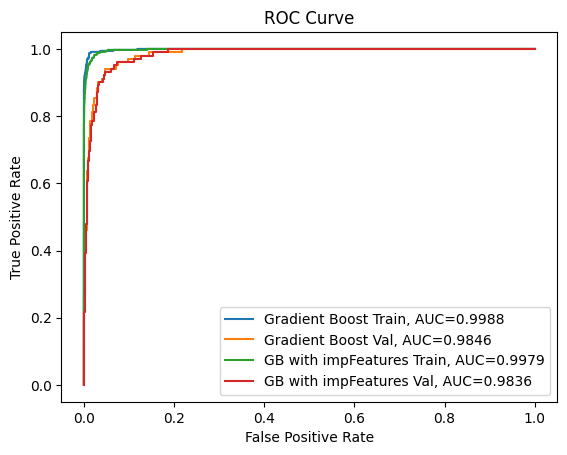

In [11]:
# 3.3 To plot ROC curve and the AUC metric - for comparison of model performances
#To plot ROC curve and the AUC metric
from sklearn import metrics

# Set up plotting area
plt.figure(0).clf()

# Gradient Boost- Train
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs_gb1)
auc = round(metrics.roc_auc_score(y_train, y_train_probs_gb1), 4)
plt.plot(fpr, tpr, label="Gradient Boost Train, AUC="+str(auc))

# Gradient Boost - Validation
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_probs_gb1)
auc = round(metrics.roc_auc_score(y_val, y_val_probs_gb1), 4)
plt.plot(fpr, tpr, label="Gradient Boost Val, AUC="+str(auc))

# Gradient Boost with important featues- Train
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs_gb2)
auc = round(metrics.roc_auc_score(y_train, y_train_probs_gb2), 4)
plt.plot(fpr, tpr, label="GB with impFeatures Train, AUC="+str(auc))

# Gradient Boost with important featues - Validation
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_probs_gb2)
auc = round(metrics.roc_auc_score(y_val, y_val_probs_gb2), 4)
plt.plot(fpr, tpr, label="GB with impFeatures Val, AUC="+str(auc))

# Add legend
plt.legend()

# Show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [12]:
# 3.4 Save the probability of the test data
y_test_probs_gb1 = gb1.predict_proba(X_test)[:, 1]


In [13]:
# 3.5 add the 'player_id'column  into the prediction probability
# Convert y_test_prob_rf3 (which is a NumPy array) to a DataFrame
y_test_probs_df = pd.DataFrame(y_test_probs_gb1, columns=['drafted'])

# Concatenate player_id_test and y_test_prob_df along the columns
Results = pd.concat([player_id_test, y_test_probs_df], axis=1)

In [14]:
Results

,player_id,drafted
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,0.000225
1,52a518bb-b34a-4b43-adee-5e996cb853fa,0.000215
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,0.000451
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,0.000261
4,55d07491-5bd1-447f-844e-9cb36eaa442e,0.000640
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,0.002958
4966,c32a466d-7a66-47eb-805c-a94e328261bc,0.000246
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,0.000225
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,0.000225


In [15]:
#3.6 save the probability as CSV file

# Convert to DataFrame and save
pd.DataFrame(Results).to_csv('../data/external/GB_Results.csv', index=False)

#3.7 save the model
# Import dump from joblib
from joblib import dump

# 3.12 Save the model and call the files respectively GB.joblib 
dump(gb1, '../models/GB.joblib')


['../models/GB.joblib']